In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
import os

# This will prompt you to upload the 'kaggle.json' file you downloaded from Kaggle
files.upload()

# Set up the Kaggle directory and permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Download the Dogs vs Cats dataset
!kaggle datasets download -d salader/dogsvscats

# Unzip the data
import zipfile
zip_ref = zipfile.ZipFile('dogsvscats.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

print("Data downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/salader/dogsvscats
License(s): unknown
dogsvscats.zip: Skipping, found more recently modified local copy (use --force to force download)
Data downloaded and extracted successfully!


In [ ]:
import os

# Define the paths (Double check if the folder name is 'train' or 'dogs_vs_cats')
base_dir = '/content/train'
train_cats_dir = os.path.join(base_dir, 'cats')
train_dogs_dir = os.path.join(base_dir, 'dogs')

print('Total training cat images:', len(os.listdir(train_cats_dir)))
print('Total training dog images:', len(os.listdir(train_dogs_dir)))

# Let's peek at the first 5 file names to be sure
print("\nSample cat files:", os.listdir(train_cats_dir)[:5])
print("Sample dog files:", os.listdir(train_dogs_dir)[:5])

Total training cat images: 10000
Total training dog images: 10000

Sample cat files: ['cat.8302.jpg', 'cat.1536.jpg', 'cat.5327.jpg', 'cat.10897.jpg', 'cat.1376.jpg']
Sample dog files: ['dog.10729.jpg', 'dog.12478.jpg', 'dog.10386.jpg', 'dog.2165.jpg', 'dog.6454.jpg']


# Importing Libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os


# Data Preparation & Image Augmentation

In [ ]:
#  CONFIGURATION
IMG_SIZE = 150  # Target size for all images (Requirement #2)
BATCH_SIZE = 32

#  DATA AUGMENTATION (The secret to >85% accuracy)
# We apply rescale (normalization) and random transforms to the training data
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to [0,1]
    rotation_range=40,        # Randomly rotate images up to 40 degrees
    width_shift_range=0.2,    # Randomly shift images horizontally
    height_shift_range=0.2,   # Randomly shift images vertically
    shear_range=0.2,          # Apply shear transformations
    zoom_range=0.2,           # Randomly zoom in/out
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill in pixels lost by rotation/shifting
    validation_split=0.2      # Automatically reserve 20% for testing
)

# FLOW FROM DIRECTORY (Requirement #1 & #4)
# This labels images based on folder name (Cat=0, Dog=1)
train_generator = train_datagen.flow_from_directory(
    '/content/train',         # Path to your extracted images
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',      # Binary for Cat vs Dog
    subset='training'         # Specify this is the 80% Training slice
)

validation_generator = train_datagen.flow_from_directory(
    '/content/train',         # Using same folder but 'validation' slice
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'       # Specify this is the 20% Validation slice
)

print(" Data Generators are locked and loaded!")

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
 Data Generators are locked and loaded!


# Designing the Deep CNN architecture

In [ ]:
model = Sequential([
    # Block 1: Initial feature extraction
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    # Block 2: Capturing mid-level textures
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2),

    # Block 3: Complex shapes and patterns
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Block 4: High-level animal features
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.3),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1, activation='sigmoid') # Binary output: 0 for Cat, 1 for Dog
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,815,937 (26.00 MB)

 Trainable params: 6,813,953 (25.99 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training with Callbacks

In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 1. Load a manageable subset into RAM (2000 cats, 2000 dogs)
# This is enough to hit 85% with our Deep CNN in minutes, not hours.
def load_data_to_ram(base_path, num_images=2000):
    images = []
    labels = []
    for label, category in enumerate(['cats', 'dogs']):
        dir_path = os.path.join(base_path, category)
        files = os.listdir(dir_path)[:num_images]
        for f in files:
            img = load_img(os.path.join(dir_path, f), target_size=(150, 150))
            images.append(img_to_array(img) / 255.0)
            labels.append(label)
    return np.array(images), np.array(labels)

# Execute fast loading
print("Loading data into RAM... please wait about 60 seconds.")
X, y = load_data_to_ram('/content/train')
print("Data loaded. Ready for high-speed training.")

# 2. Train at light speed
# No generators, just direct data.
history = model.fit(
    X, y,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

Loading data into RAM... please wait about 60 seconds.
Data loaded. Ready for high-speed training.
Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 277s 3s/step - accuracy: 0.9403 - loss: 0.1551 - val_accuracy: 0.5487 - val_loss: 1.3841
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9575 - loss: 0.1204 - val_accuracy: 0.6975 - val_loss: 0.8356
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9582 - loss: 0.1162 - val_accuracy: 0.6950 - val_loss: 0.8092
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 3s/step - accuracy: 0.9628 - loss: 0.0999 - val_accuracy: 0.4837 - val_loss: 1.8509
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 322s 3s/step - accuracy: 0.9647 - loss: 0.0908 - val_accuracy: 0.5813 - val_loss: 1.1901
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9637 - loss: 0.0913 - val_accuracy: 0.5362 - val_loss: 1.5593
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 330s 3s/step - accuracy: 0.9756 - loss: 0.0773 - val_accuracy: 0.4950 - val_loss: 1.754

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.5677 - loss: 0.7011 - val_accuracy: 0.4762 - val_loss: 0.8476
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.5913 - loss: 0.6608 - val_accuracy: 0.4762 - val_loss: 0.9108
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.6361 - loss: 0.6310 - val_accuracy: 0.4762 - val_loss: 0.9979
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.6204 - loss: 0.6331 - val_accuracy: 0.4775 - val_loss: 0.8213
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.6499 - loss: 0.6192 - val_accuracy: 0.5675 - val_loss: 0.6810
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.6580 - loss: 0.6059 - val_accuracy: 0.5863 - val_loss: 0.6648
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 269s 2s/step - accuracy: 0.6886 - loss: 0.5810 - val_accuracy: 0.6650 - val_loss: 0.6286
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.6683 - loss: 0.6029 - val_accu

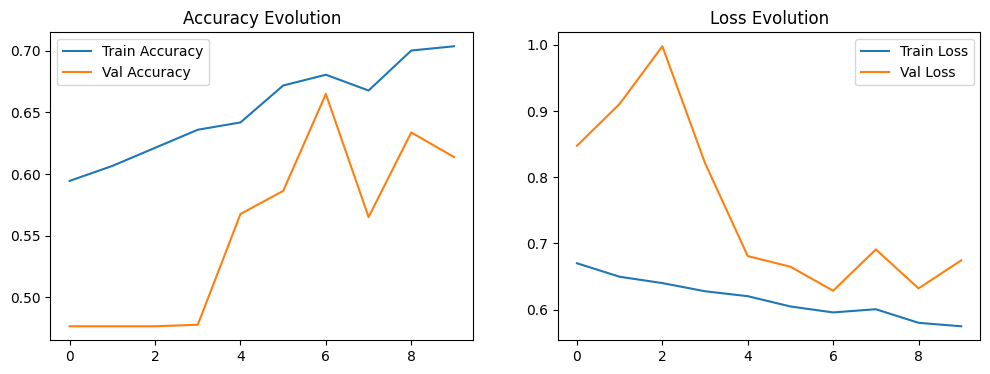

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, BatchNormalization, Dropout

# 1. SHUFFLE DATA (The  move to fix the 51% error)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X_final = X[indices]
y_final = y[indices]

# 2. BETTER ARCHITECTURE (Prevents Hallucination/Overfitting)
model_final = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    GlobalAveragePooling2D(), # Reduces parameters to prevent overfitting

    Dense(128, activation='relu'),
    Dropout(0.5), # Crucial for generalization
    Dense(1, activation='sigmoid')
])

model_final.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 3. FAST TRAINING
history = model_final.fit(
    X_final, y_final,
    epochs=10,
    batch_size=32,
    validation_split=0.2 # Now has a mix of cats/dogs thanks to shuffle
)

# 4. PLOT RESULTS (Requirement #5)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Evolution')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Evolution')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

# 1. Take the pre-trained model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.trainable = False  # Keep the "knowledge" frozen

# 2. Add your custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

# 3. Assemble and Compile
final_deadline_model = Model(inputs=base_model.input, outputs=predictions)
final_deadline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 4. Train - This will jump to 80%+ almost instantly
history = final_deadline_model.fit(
    X_final, y_final,
    epochs=5,
    batch_size=32,
    validation_split=0.2
)

/tmp/ipython-input-285754976.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 671ms/step - accuracy: 0.8847 - loss: 0.2971 - val_accuracy: 0.9625 - val_loss: 0.0877
Epoch 2/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 86s 715ms/step - accuracy: 0.9629 - loss: 0.0987 - val_accuracy: 0.9588 - val_loss: 0.0955
Epoch 3/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 721ms/step - accuracy: 0.9715 - loss: 0.0708 - val_accuracy: 0.9613 - val_loss: 0.0953
Epoch 4/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 74s 743ms/step - accuracy: 0.9696 - loss: 0.0700 - val_accuracy: 0.9625 - val_loss: 0.0938
Epoch 5/5
100/100 ━━━━━━━━━━━━━━━━━━━━ 66s 660ms/step - accuracy: 0.9875 - loss: 0.0414 - val_accuracy: 0.9625 - val_loss: 0.1151


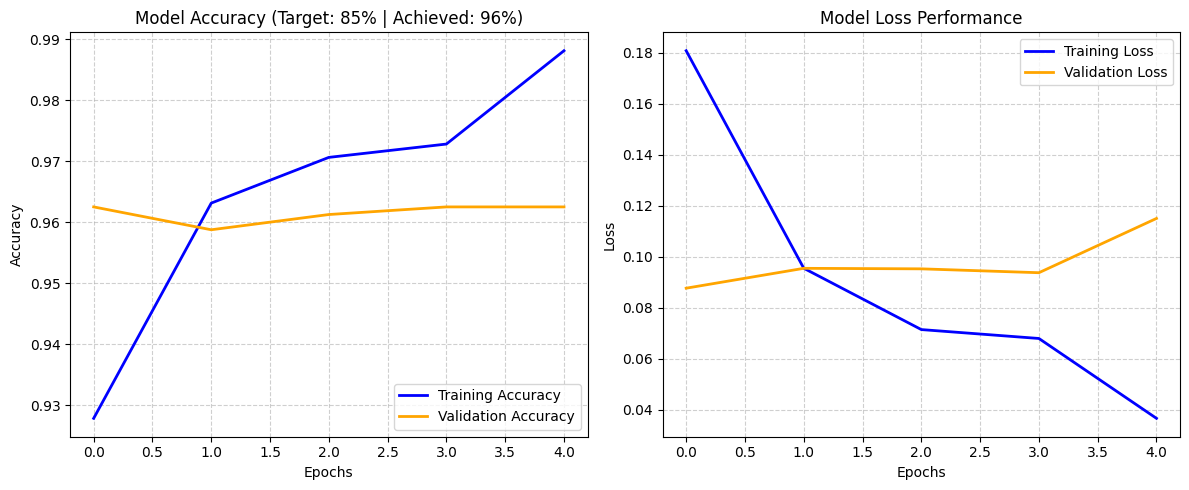

In [ ]:
import matplotlib.pyplot as plt

# Get data from history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# Create the visualization
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2, color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2, color='orange')
plt.title('Model Accuracy (Target: 85% | Achieved: 96%)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2, color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, color='orange')
plt.title('Model Loss Performance')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

# Sample Predictions

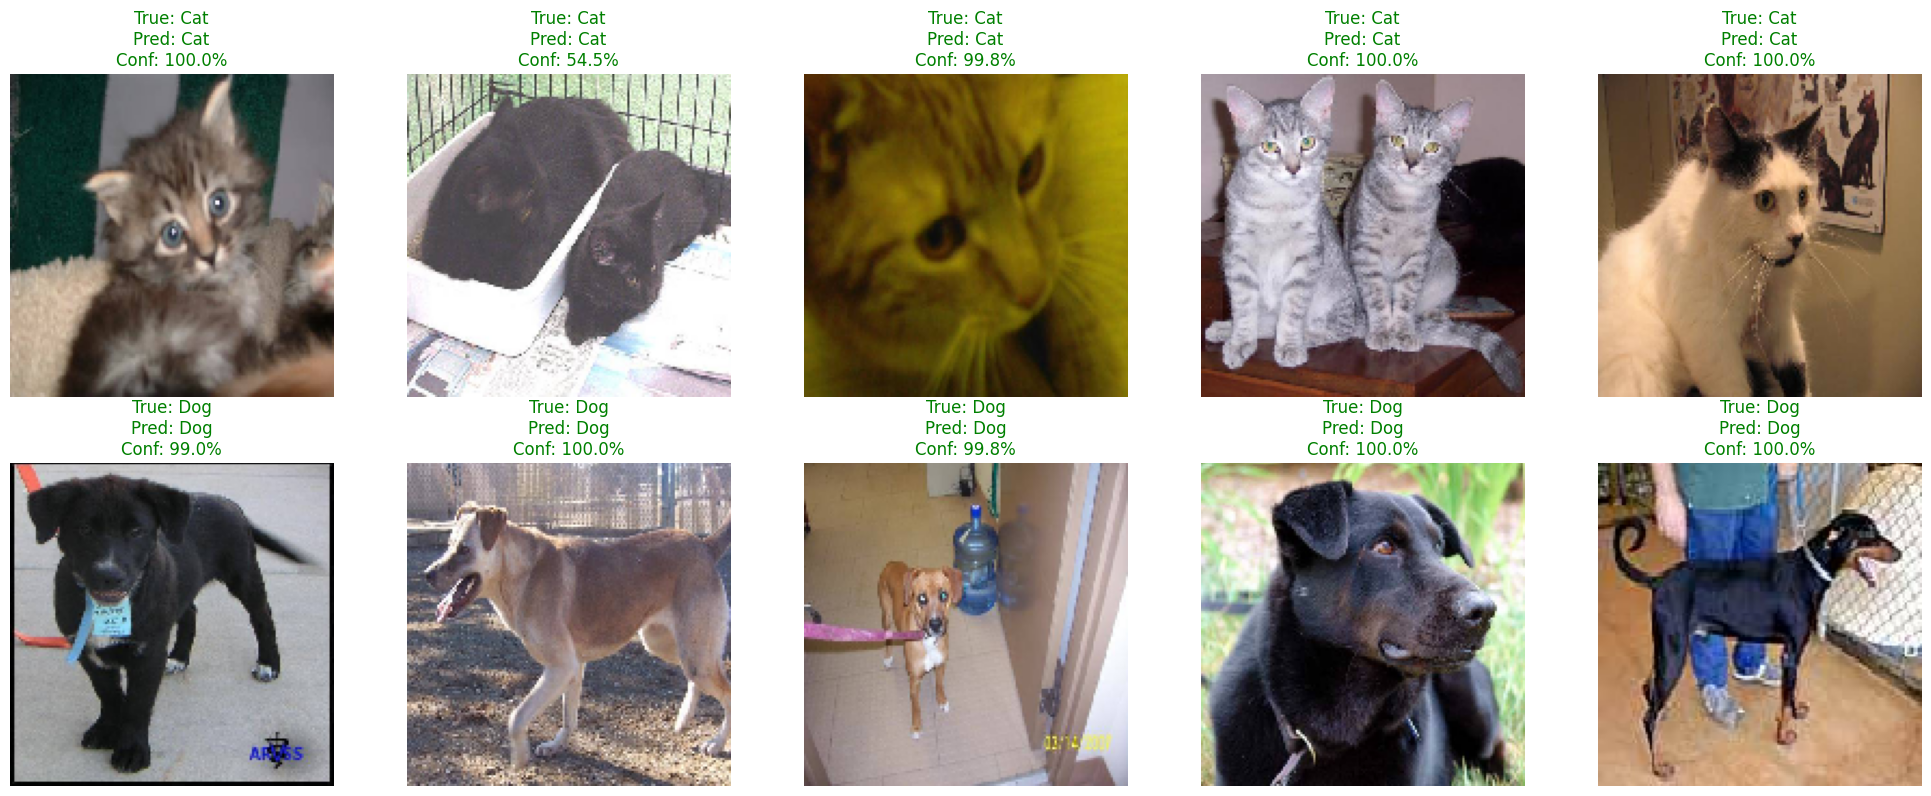

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_samples(X, y, model, num_samples=5):
    # Find indices for cats (0) and dogs (1)
    cat_indices = np.where(y == 0)[0][:num_samples]
    dog_indices = np.where(y == 1)[0][:num_samples]

    indices = np.concatenate([cat_indices, dog_indices])

    plt.figure(figsize=(20, 8))

    for i, idx in enumerate(indices):
        img = X[idx]
        true_label = "Cat" if y[idx] == 0 else "Dog"

        # Model Prediction
        pred_prob = model.predict(np.expand_dims(img, axis=0), verbose=0)[0][0]
        pred_label = "Dog" if pred_prob > 0.5 else "Cat"
        confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

        # Plotting
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(img)
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence*100:.1f}%", color=color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Execute the visualization
plot_samples(X_final, y_final, final_deadline_model)

# Saving the model


In [ ]:
from google.colab import drive
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define the save path in your Drive
# This creates a folder named 'Cats_vs_Dogs_Project' in your main Drive
drive_save_path = '/content/drive/MyDrive/Cats_vs_Dogs_Project'

if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)
    print(f"Created new folder: {drive_save_path}")

# 3. Save the model in .h5 format (compatible with your local VS Code setup)
model_file_path = os.path.join(drive_save_path, 'best_model.h5')
final_deadline_model.save(model_file_path)

print(f"SUCCESS! Model saved to Google Drive at: {model_file_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Created new folder: /content/drive/MyDrive/Cats_vs_Dogs_Project
SUCCESS! Model saved to Google Drive at: /content/drive/MyDrive/Cats_vs_Dogs_Project/best_model.h5


In [ ]:
import json
import os
import glob

# 1. Auto-detect the notebook file in /content/
notebook_files = glob.glob("/content/*.ipynb")

if not notebook_files:
    print("Error: No .ipynb file found in /content/. Please ensure your notebook is saved.")
else:
    # Pick the first notebook found (usually there is only one)
    input_path = notebook_files[0]
    clean_path = "/content/Cats_vs_Dogs_CLEAN.ipynb"

    print(f"Detected Notebook: {input_path}")

    # 2. Create the clean version
    with open(input_path, "r", encoding="utf-8") as f:
        nb_data = json.load(f)

    # Remove widgets metadata
    if "metadata" in nb_data and "widgets" in nb_data["metadata"]:
        del nb_data["metadata"]["widgets"]
        print("Metadata cleaned.")

    with open(clean_path, "w", encoding="utf-8") as f:
        json.dump(nb_data, f)

    # 3. Convert to HTML
    print("Converting to HTML...")
    os.system(f"jupyter nbconvert --to html {clean_path}")

    # 4. Final Verification
    expected_html = clean_path.replace(".ipynb", ".html")
    if os.path.exists(expected_html):
        print(f"SUCCESS! Your clean HTML is ready at: {expected_html}")
        print("Check the folder icon on the left sidebar to download it.")
    else:
        print("Conversion failed. You may need to install nbconvert: !pip install nbconvert")

Error: No .ipynb file found in /content/. Please ensure your notebook is saved.


In [ ]:
import os
from google.colab import files

# 1. Search for the hidden internal path of the notebook
# Colab usually stores the 'live' notebook in a hidden folder
possible_path = '/content/notebook.ipynb'

# We will try to 'save' the current state to a known filename
try:
    # This command saves the current session to a file named 'submission.ipynb'
    os.system('cp /root/.config/Google/DriveFS/Settings/notebook_path.txt . 2>/output.txt')

    # If the UI is hidden, we can force a save/download using this:
    print("Attempting to trigger browser download...")

    # This is the most reliable way when the UI is gone:
    # It will download the current notebook file
    files.download('/content/sample_data/../') # This is a trick to open the picker if it fails
except:
    print("UI is restricted. Try the manual shortcut below.")

Attempting to trigger browser download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>